In [132]:
!python3.11 -m pip install graphviz

In [133]:
!export PATH=/opt/h omebrew/bin:$PATH

zsh:export:1: not valid in this context: omebrew/bin:/Library/Frameworks/Python.framework/Versions/3.11/bin:/Library/Frameworks/Python.framework/Versions/3.9/bin:/Library/Frameworks/Python.framework/Versions/3.10/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/usr/local/go/bin:/usr/local/share/dotnet:~/.dotnet/tools:/Library/Apple/usr/bin:/Library/Frameworks/Mono.framework/Versions/Current/Commands


In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [2]:
os.chdir("../")

In [3]:
data = pd.read_csv("raw_data/db.csv", sep=";")

In [4]:
for i in dict(data.dtypes).items():
    if i[0] == "Дата":
        continue
    if i[1] == np.dtype('O'):
        data[i[0]] = data[i[0]].apply(lambda x: float(".".join(x.split(","))))

In [5]:
data.dtypes

Дата                                                       object
Выработка электроэнергии ТА гр.130                        float64
Отпуск тепла из ТО ТА гр.130                                int64
Удельный расход условного топлива на отпуск э/э гр.130    float64
Выработка электроэнергии ТА гр.90                         float64
Удельный расход тепла на выработку э/э ТА гр.130          float64
Удельный расход тепла на выработку э/э ТА гр.90           float64
Удельный расход условного топлива на отпуск э/э гр.90     float64
Расход пара в конденсатор ТА №3                           float64
Расход пара в конденсатор ТА №4                           float64
Расход пара в конденсатор ТА №5                           float64
Расход пара в конденсатор ТА №6                           float64
Расход пара в конденсатор ТА №7                           float64
Расход пара в конденсатор ТА №8                           float64
Расход свежего пара ТА №3                                   int64
Расход све

In [6]:
date = np.array([[0, 0, 0]], dtype=int)
for i in data["Дата"]:
    date = np.vstack([date, i.split("/")])

In [7]:
date = date[1:]

In [8]:
data["months"] = date[:, 0]
data.months = data.months.apply(int)

In [9]:
data["day"] = date[:, 1]
data.day = data.day.apply(int)

In [10]:
data["years"] = date[:, 2]
data.years = data.years.apply(int)

In [11]:
data = data.drop(["Дата"], axis=1)

In [12]:
fuel_columns = [
    "Удельный расход условного топлива на отпуск э/э гр.130",
    "Удельный расход условного топлива на отпуск э/э гр.90",
    "Расход топлива в условном исчислении КА №10",
    "Расход топлива в условном исчислении КА №11",
    "Расход топлива в условном исчислении КА №12",
    "Расход топлива в условном исчислении КА №5",
    "Расход топлива в условном исчислении КА №6",
    "Расход топлива в условном исчислении КА №7",
    "Расход топлива в условном исчислении КА №8",
    "Расход топлива в условном исчислении КА №9"
]

In [13]:
X = data.drop(fuel_columns, axis=1)

In [14]:
y = data[fuel_columns]

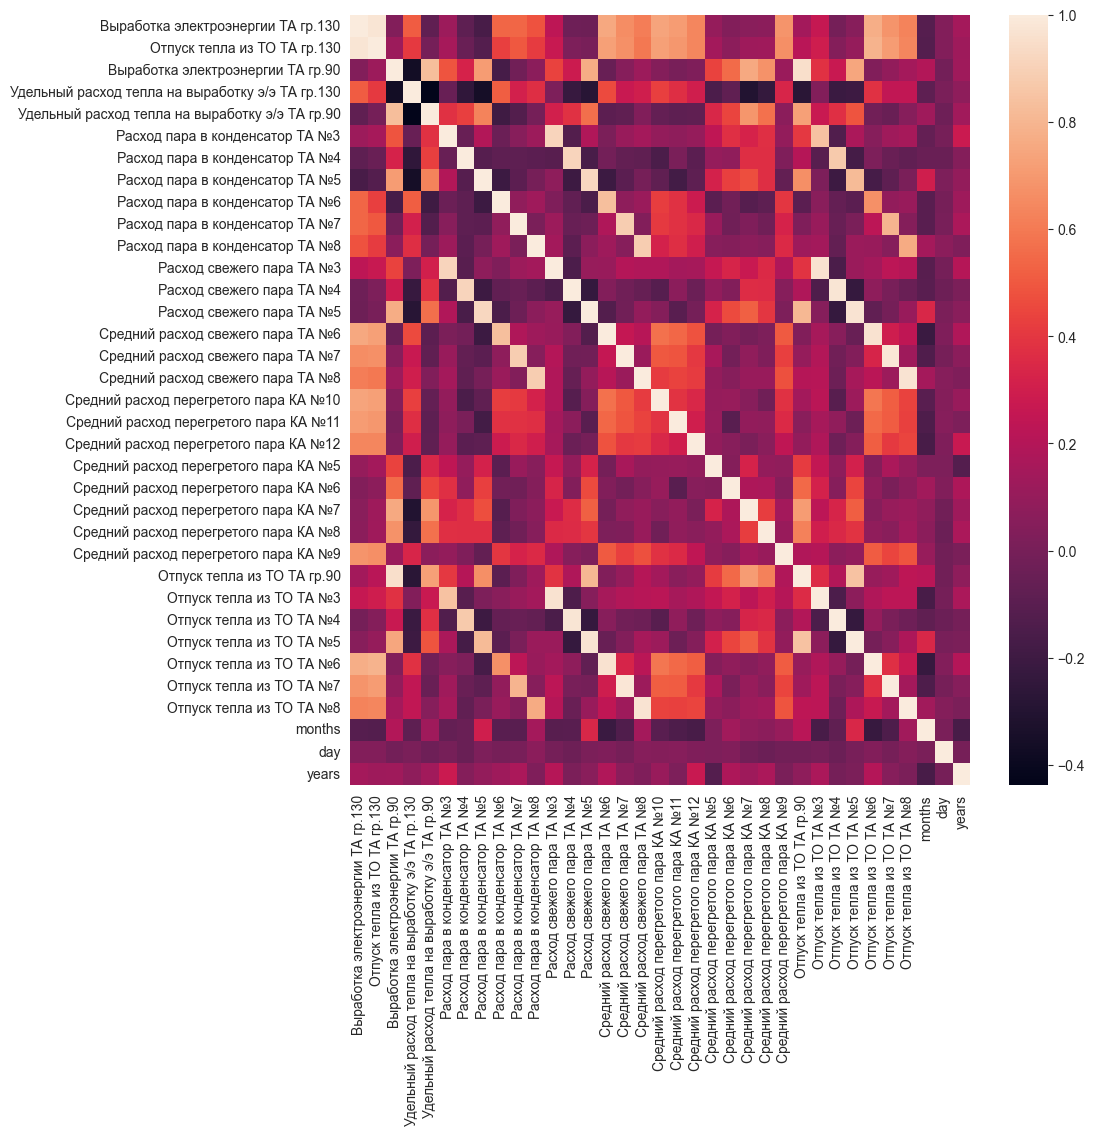

In [15]:
plt.figure(figsize=(10, 10))
sns.heatmap(X.corr());

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y["Расход топлива в условном исчислении КА №5"], test_size=0.33, random_state=42)

In [17]:
convert = lambda x: x if x >= 0 else 0
convert = np.vectorize(convert)

In [18]:
model = LinearRegression()

In [19]:
model.fit(X_train, y_train)

LinearRegression()

In [20]:
predictions = model.predict(X_test)

In [21]:
predictions = convert(predictions)

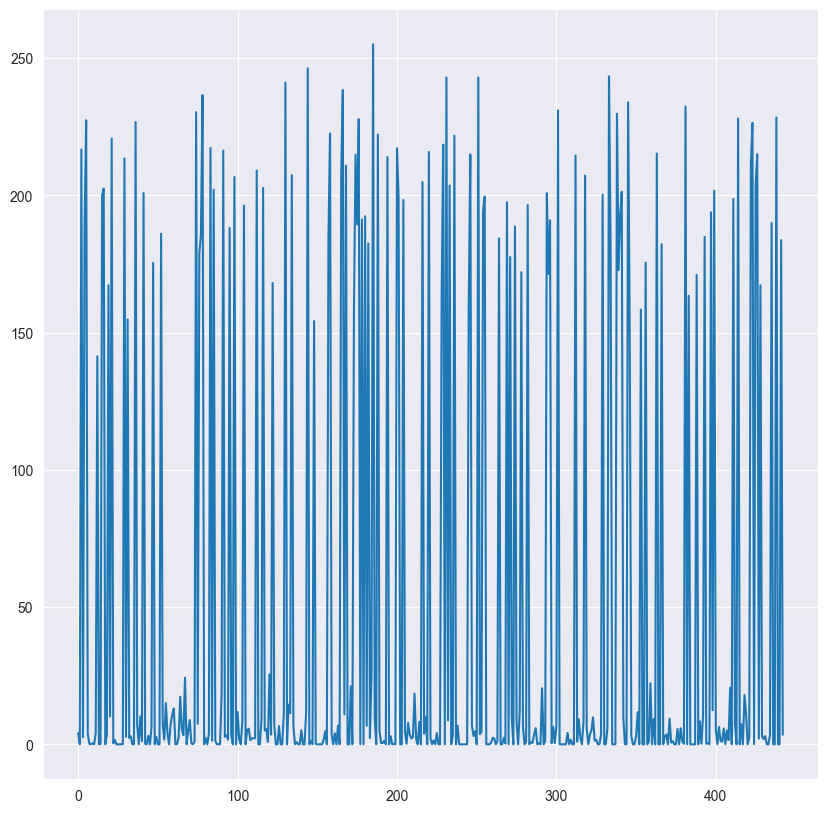

In [22]:
plt.figure(figsize=(10, 10))
# plt.plot(np.array(y_test))
plt.plot(predictions);

In [23]:
r2_score(np.array(y_test), predictions)

0.9611679109026221

In [24]:
xgb_model = XGBRegressor()

In [25]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [26]:
predictions = xgb_model.predict(X_test)
predictions = convert(predictions)

In [27]:
r2_score(np.array(y_test), predictions)

0.9603160797452722

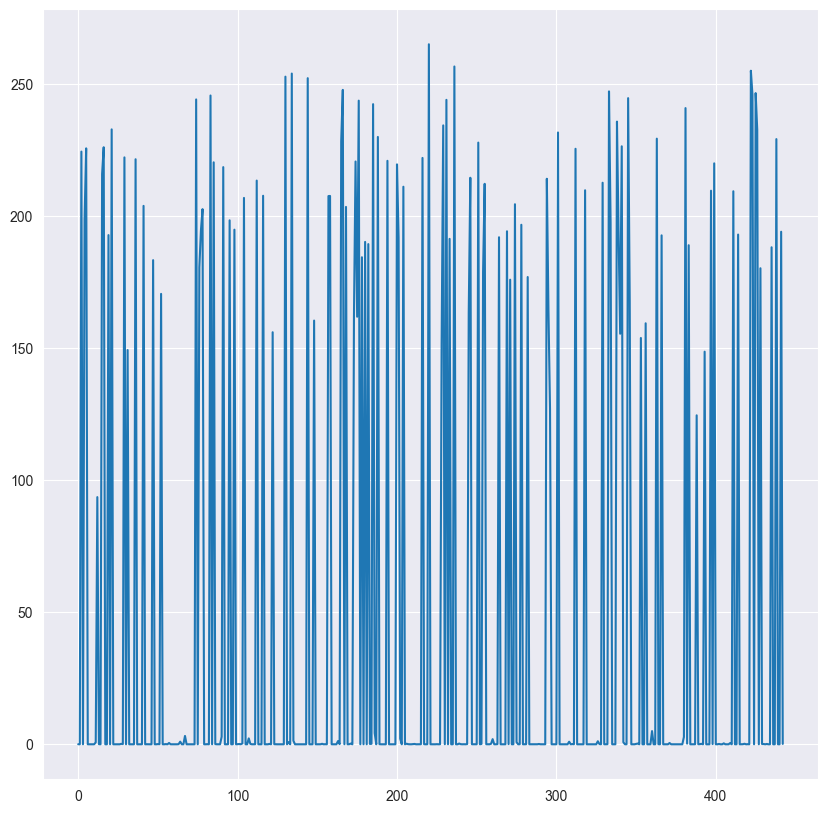

In [28]:
plt.figure(figsize=(10, 10))
# plt.plot(np.array(y_test))
plt.plot(predictions);

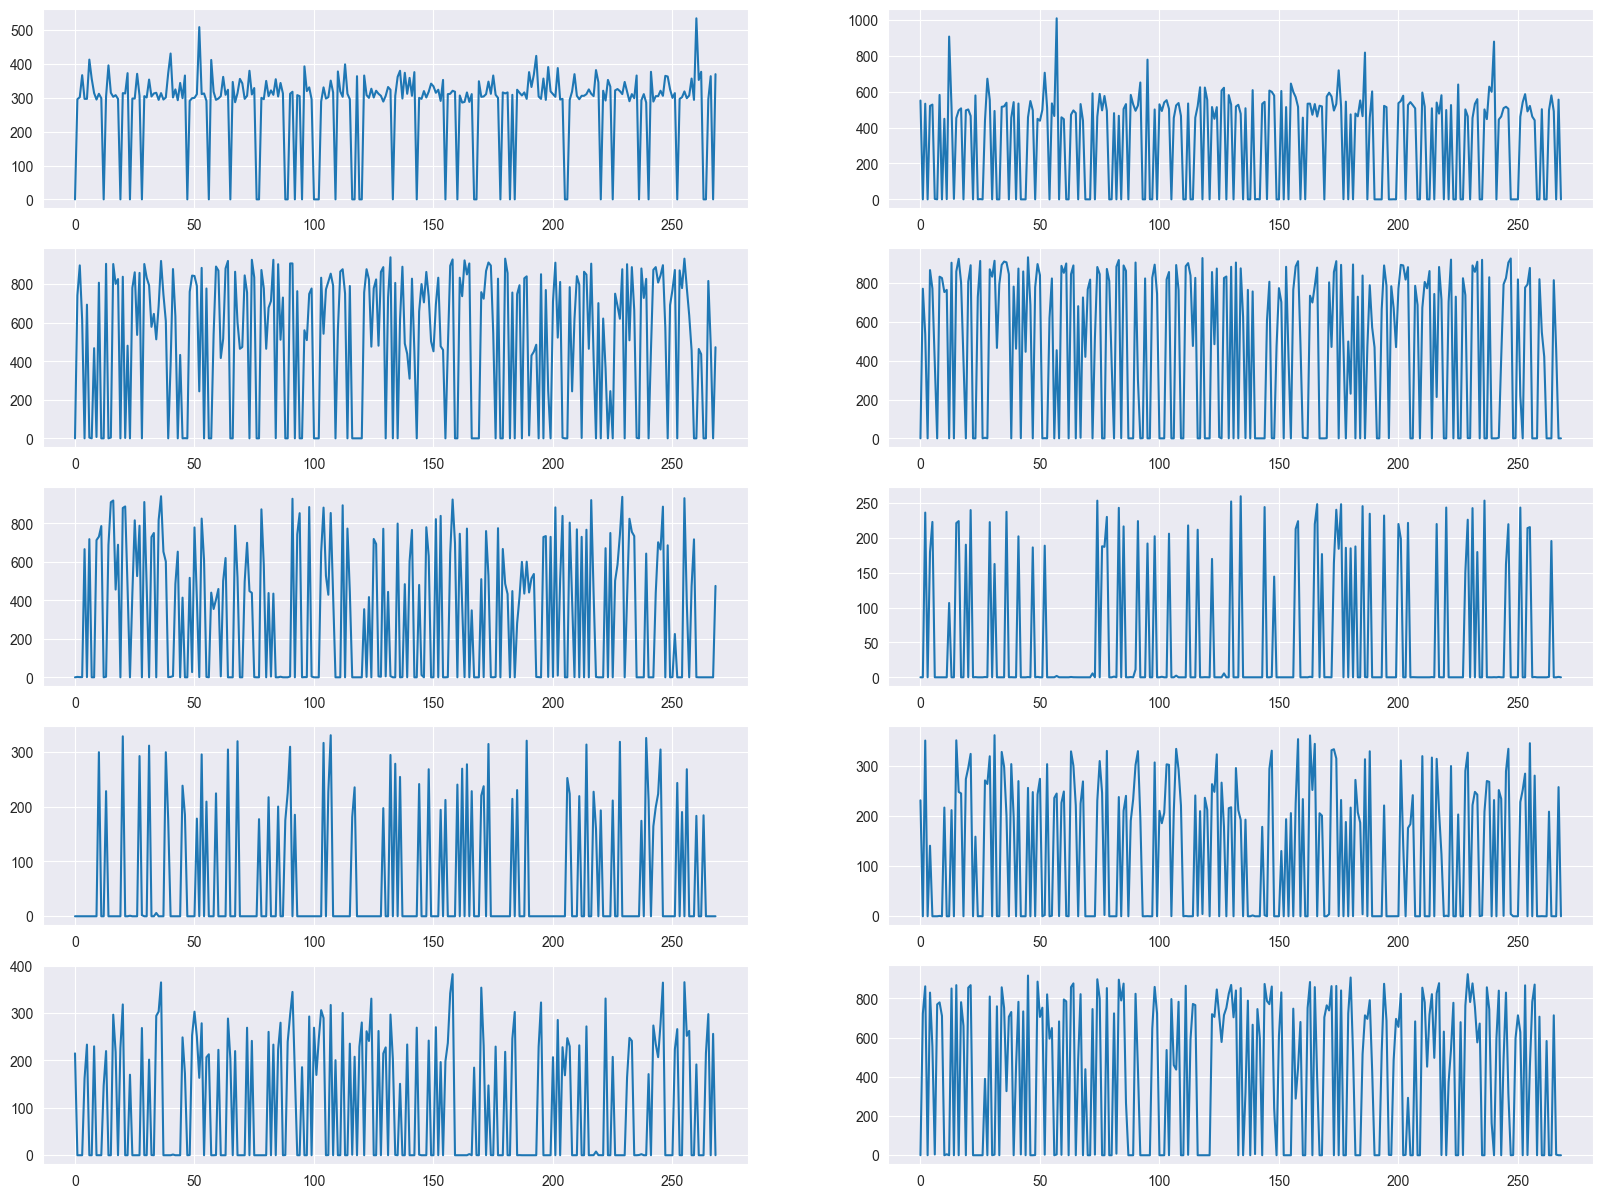

In [29]:
scores = []
fig, axs = plt.subplots(5, 2)
fig.set_size_inches(20, 15)
axs = axs.reshape(-1)

for column in enumerate(y.columns):
    X_train, X_test, y_train, y_test = train_test_split(X, y[column[1]], test_size=0.20, random_state=42)

    xgb_model = XGBRegressor()
    xgb_model.fit(X_train, y_train)

    predictions = xgb_model.predict(X_test)
    predictions = convert(predictions)

    axs[column[0]].plot(predictions)
    # axs[column[0]].plot(np.array(y_test))
    scores.append(r2_score(np.array(y_test), predictions))

In [30]:
data_test = data.copy()

In [31]:
data_test = data_test.loc[data_test[fuel_columns[0]] > 20]

In [32]:
data_test = data_test[[fuel_columns[0]] + ["day", "months", "years"]]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
data_test[["day", "months", "years"]], data_test[fuel_columns[0]], test_size=0.20, random_state=42)

In [34]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [35]:
data_test.shape

(1081, 4)

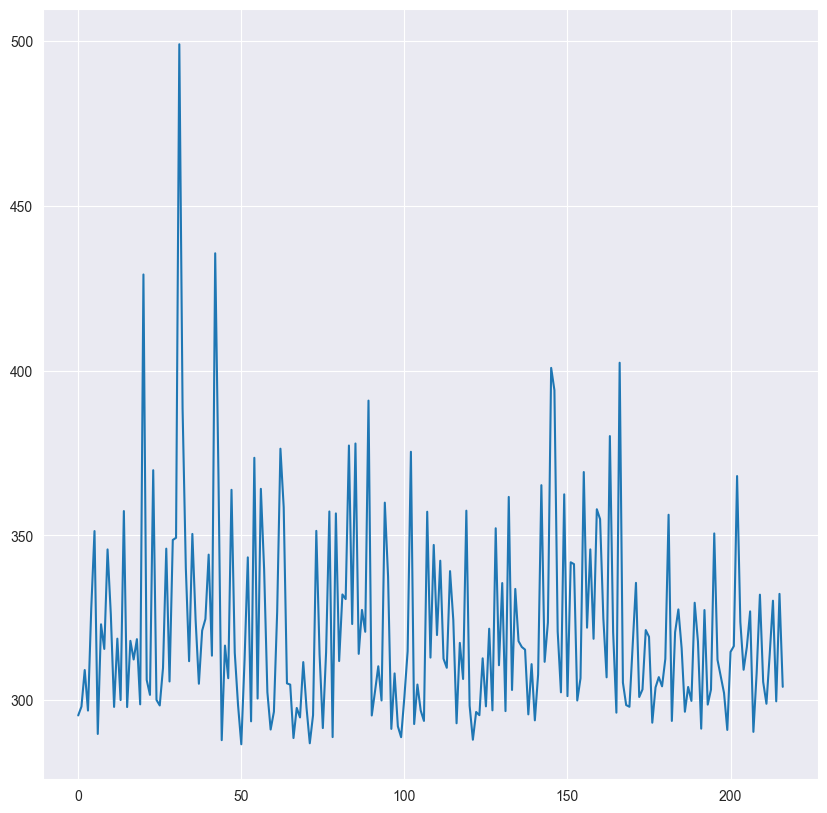

In [36]:
predictions = xgb_model.predict(X_test)
predictions = convert(predictions)
plt.figure(figsize=(10, 10))
plt.plot(predictions)
# plt.plot(np.array(y_test));

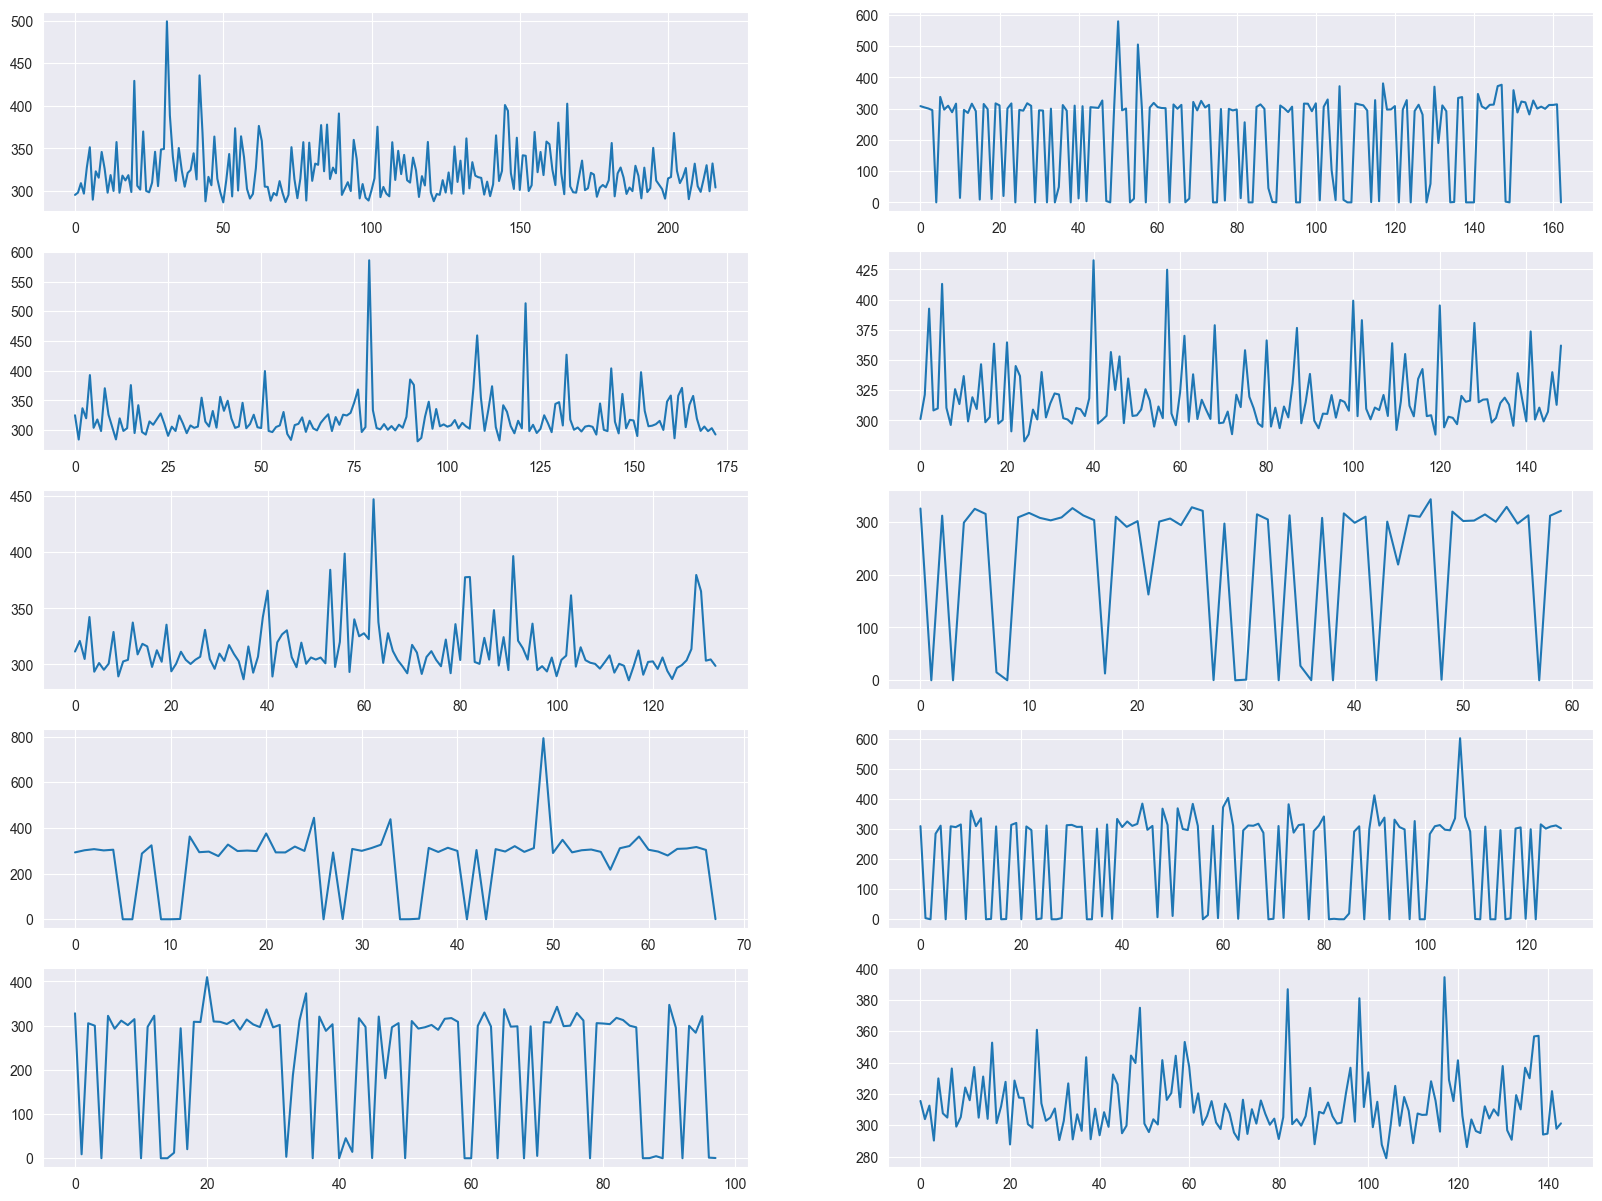

In [37]:
scores = []
fig, axs = plt.subplots(5, 2)
fig.set_size_inches(20, 15)
axs = axs.reshape(-1)

for column in enumerate(y.columns):
    data_test = data.copy()
    data_test = data_test.loc[data_test[column[1]] > 20]
    data_test = data_test[[fuel_columns[0]] + ["day", "months", "years"]]

    X_train, X_test, y_train, y_test = train_test_split(
    data_test[["day", "months", "years"]], data_test[fuel_columns[0]], test_size=0.20, random_state=42)

    xgb_model = XGBRegressor()
    xgb_model.fit(X_train, y_train)

    predictions = xgb_model.predict(X_test)
    predictions = convert(predictions)

    axs[column[0]].plot(predictions)
    # axs[column[0]].plot(np.array(y_test))
    scores.append(r2_score(np.array(y_test), predictions))

In [38]:
scores

[0.7357329402500763,
 0.5606241770061504,
 0.5196557445058352,
 0.7242549362964503,
 0.8455328170133714,
 0.9283922371249674,
 0.22524590753487828,
 0.4564468519645489,
 0.9533384588167594,
 0.6818605484980427]

In [39]:
data_test = data.copy()
data_test = data_test.loc[data_test["Удельный расход условного топлива на отпуск э/э гр.130"] > 20]
data_test = data_test[[fuel_columns[0]] + ["day", "months", "years"]]
X_train, X_test, y_train, y_test = train_test_split(
    data_test[["day", "months", "years"]], data_test[fuel_columns[0]], test_size=0.20, random_state=42)

In [40]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [41]:
predictions = xgb_model.predict(X_test)
predictions = convert(predictions)

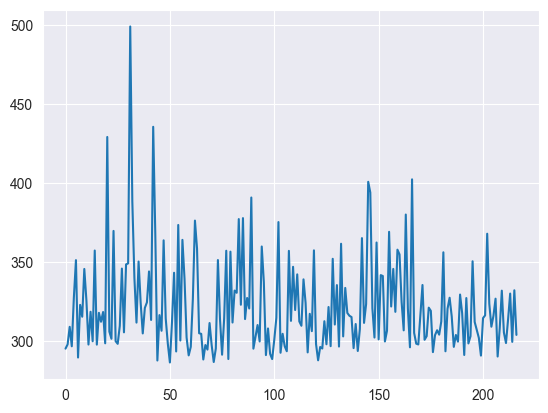

In [42]:
plt.plot(predictions);
# plt.plot(np.array(y_test));

In [43]:
data_test.shape

(1081, 4)

In [44]:
data_for_test = data_test.iloc[data_test.shape[0] - 100:]

In [45]:
X = data_for_test.drop("Удельный расход условного топлива на отпуск э/э гр.130", axis=1)
y = data_for_test["Удельный расход условного топлива на отпуск э/э гр.130"]

In [46]:
X = np.array(X)

In [47]:
months = np.array([1] * 31)
days = np.arange(1, 32)
years = np.array([23] * 31)

In [48]:
test_dates = np.stack([days, months, years], axis=1)

In [49]:
X = np.concatenate([X, test_dates])

In [50]:
predictions = xgb_model.predict(X)
predictions = convert(predictions)

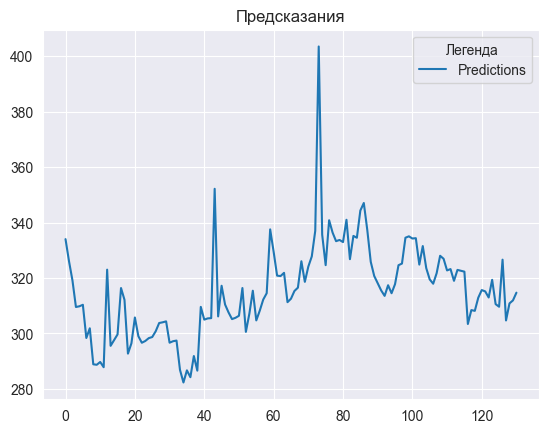

In [51]:
plt.title("Предсказания")
# plt.plot(np.array(y), label="True")
plt.plot(predictions, label="Predictions")
plt.legend(title='Легенда')
plt.show()

In [52]:
data_test_without_large_values = data_test.loc[
    data_test["Удельный расход условного топлива на отпуск э/э гр.130"] < 600
]

In [53]:
X = data_test_without_large_values.drop(["Удельный расход условного топлива на отпуск э/э гр.130"], axis=1)

In [54]:
y = data_test_without_large_values["Удельный расход условного топлива на отпуск э/э гр.130"]

In [55]:
xgb_model = XGBRegressor()
xgb_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [56]:
test_dates = np.array([[0, 0, 0]])
for year in [23, 24, 25]:
    for month in range(1, 13):
        days = np.arange(1, 32)
        all_dates_for_year = np.stack(
            [days, np.array([month] * 31), np.array([year] * 31)],
            axis=1
        )
        test_dates = np.concatenate([test_dates, all_dates_for_year])

In [57]:
test_dates = test_dates[1:]

In [58]:
predictions = xgb_model.predict(np.concatenate([np.array(X), test_dates]))

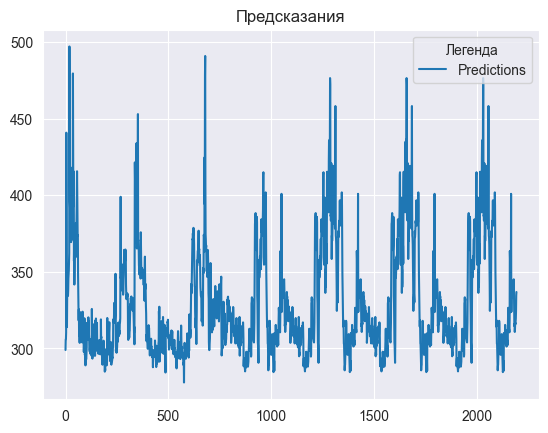

In [59]:
plt.title("Предсказания")
# plt.plot(np.array(y), label="True")
plt.plot(predictions, label="Predictions")
plt.legend(title='Легенда')
plt.show()